# World Happiness & Economic and social indicators correlations

- **Year:** The year for which the data is recorded(e.g., 2015, 2020, 2024)
- **Country:** The name of the country.
- **GDP_per_capita:** Gross Domestic Product per capita, which is a measure of a country's economic outout per person.
- **Education_Attainment:** The level of education achieved by the population.
- **Life_Expectancy:** The average number of years a person is expected to live.
- **Unemployment_Rate:** The percentage of the labour force that is unemployed.
- **Happiness Score:** A metric measuring the self-reported happiness of individuals in a country.

In [121]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
import warnings

# Version Check
print(f"pandas: {pd.__version__}, numpy: {np.__version__}, sklearn: {sklearn.__version__}, seaborn: {sns.__version__}")

# Warnings Off
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load Datasets
def load_dataset(path):
    """Load CSV dataset with standard parameters."""
    return pd.read_csv(path, encoding='utf-8-sig', skip_blank_lines=True)

merged = load_dataset('../data/processed/merged_dataset.csv')

pandas: 2.2.3, numpy: 2.2.2, sklearn: 1.6.1, seaborn: 0.13.2


# Exploratory Data Analysis (EDA)

## 1. Introduction
In this section, I will explore and anlyse the datasets to understand their structure, relationships, and potential issues. The main objectvies of this EDA are:
- To understand the dataset's structure.
- To indentify missing values and handle them.
- To explore statistical summarise and data distributtions.
- To identify patterns and correlations between variables.

## 2. General Information

In [122]:
# Check basic information about the datasets (shape, columns, data types, etc.)
merged.info()

# Summary statistics of the dataset
merged.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1217 entries, 0 to 1216
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Country               1217 non-null   object 
 1   Year                  1217 non-null   int64  
 2   GDP_per_capita        1216 non-null   float64
 3   Education_Attainment  760 non-null    float64
 4   Life_Expectancy       1115 non-null   float64
 5   Unemployment_Rate     1217 non-null   float64
 6   Happiness Score       1217 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 66.7+ KB


,Year,GDP_per_capita,Education_Attainment,Life_Expectancy,Unemployment_Rate,Happiness Score
count,1217.000000,1216.000000,760.000000,1115.000000,1217.000000,1217.000000
mean,2018.928513,16353.942843,18.906597,72.606489,6.993130,5.489727
std,2.570835,22305.699127,11.549346,8.017450,5.373851,1.134327
min,2015.000000,210.008140,0.000000,51.589000,0.110000,1.721000
25%,2017.000000,1911.650678,9.487251,66.226000,3.590000,4.607000
50%,2019.000000,5979.651050,18.016045,74.170000,5.232000,5.533000
75%,2021.000000,22337.946193,28.709417,79.279500,8.922000,6.324000
max,2023.000000,133711.794436,61.090519,84.560000,35.086000,7.842000


### 2.1. Check Data Quality 

In [123]:
total_rows = len(merged)

# Calculate missing values for each column
missing_values = merged.isnull().sum()

# Calculate percentage of missing values for each column
missing_percentage = (missing_values / total_rows) * 100
missing_percentage

Country                  0.000000
Year                     0.000000
GDP_per_capita           0.082169
Education_Attainment    37.551356
Life_Expectancy          8.381265
Unemployment_Rate        0.000000
Happiness Score          0.000000
dtype: float64

## 3. Evaluating Missing Data

### 3.1. Check and handle missing values

In [124]:
# Identify features with missing values
missing_summary = merged.isnull().sum()
missing_features = missing_summary[missing_summary > 0].index.tolist()

print("📌 Features with missing values:", missing_features)

# Identify countries with all years missing per feature
total_years = merged['Year'].nunique()
fully_missing_countries = {}

for feature in missing_features:
    missing = merged[merged[feature].isnull()]
    country_missing_years = missing.groupby('Country')['Year'].nunique()
    fully_missing = country_missing_years[country_missing_years == total_years]
    
    if not fully_missing.empty:
        fully_missing_countries[feature] = fully_missing.index.tolist()

# Display results
for feature, countries in fully_missing_countries.items():
    print(f"\n❌ Feature: {feature}")
    display(pd.DataFrame({'Country': countries}))

📌 Features with missing values: ['GDP_per_capita', 'Education_Attainment', 'Life_Expectancy']


### 3.2. Evaluating Missingness Mechanism (MAR vs. MCAR)

In [140]:
from scipy.stats import ttest_ind, chi2_contingency

# Load the merged dataset
merged = pd.read_csv('../data/processed/merged_dataset.csv')

def check_mar(merged, missing_col):
    """
    Evaluate whether missing values in the given column are Missing At Random (MAR)
    using statistical comparisons between missing and non-missing groups.

    Args:
        merged (pd.DataFrame): Input DataFrame
        missing_col (str): Target column with missing values
    """
    missing_group = merged[merged[missing_col].isnull()]
    non_missing_group = merged[merged[missing_col].notnull()]

    print(f"\n🧪 Analyzing missingness for '{missing_col}'")

    if missing_group.empty:
        print("✅ No missing values found.")
        return

    # Compare numerical columns
    print("\n📊 Numerical feature comparison:")
    num_cols = merged.select_dtypes(include=np.number).drop(columns=[missing_col])
    for col in num_cols:
        try:
            t_stat, p_val = ttest_ind(missing_group[col].dropna(), non_missing_group[col].dropna(), equal_var=False)
            print(f" - {col}: t={t_stat:.2f}, p={p_val:.3f} {'✅ Significant' if p_val < 0.05 else ''}")
        except Exception as e:
            print(f" - {col}: Error during t-test ({e})")

    # Compare categorical columns (optional: exclude high cardinality ones)
    print("\n🔠 Categorical feature comparison:")
    cat_cols = merged.select_dtypes(include='object').columns
    for col in cat_cols:
        try:
            cross_tab = pd.crosstab(merged[col], merged[missing_col].isnull())
            if cross_tab.shape[0] > 1 and cross_tab.shape[1] > 1:
                chi2, p_val, _, _ = chi2_contingency(cross_tab)
                print(f" - {col}: chi2={chi2:.2f}, p={p_val:.3f} {'✅ Significant' if p_val < 0.05 else ''}")
        except Exception as e:
            print(f" - {col}: Skipped due to error ({e})")

# Example 
# check_mar(merged, 'GDP_per_capita')
check_mar(merged, 'Education_Attainment')
# check_mar(merged, 'Life_Expectancy')


🧪 Analyzing missingness for 'Education_Attainment'

📊 Numerical feature comparison:
 - Year: t=4.56, p=0.000 ✅ Significant
 - GDP_per_capita: t=-11.07, p=0.000 ✅ Significant
 - Life_Expectancy: t=-11.62, p=0.000 ✅ Significant
 - Unemployment_Rate: t=-1.20, p=0.232 
 - Happiness Score: t=-10.11, p=0.000 ✅ Significant

🔠 Categorical feature comparison:
 - Country: chi2=459.64, p=0.000 ✅ Significant


### 3.3. Missing value of `GDP_per_capita`

In [126]:
# Extract rows with missing GDP_per_capita
missing_gdp = merged[merged['GDP_per_capita'].isnull()]

print("🔍 Missing GDP entry:")
print(missing_gdp[['Country', 'Year']])

🔍 Missing GDP entry:
     Country  Year
641  lebanon  2023


In [127]:
# Get the country with missing GDP
country = missing_gdp.iloc[0]['Country']

# Check GDP trend over the years for the selected country
gdp_series = merged[merged['Country'] == country][['Year', 'GDP_per_capita']].sort_values('Year')

print(f"\n📈 GDP trend for {country}:")
print(gdp_series)


📈 GDP trend for lebanon:
     Year  GDP_per_capita
633  2015     7714.110000
634  2016     8089.012088
635  2017     8608.210850
636  2018     9174.536662
637  2019     8905.880055
638  2020     5561.191670
639  2021     4045.373911
640  2022     3654.358455
641  2023             NaN


#### 3.3.1. manual filling

In [142]:
# Manually impute Lebanon's missing 2023 GDP per capita using TradingEconomics
# Source: https://tradingeconomics.com/lebanon/gdp-per-capita-us-dollar-wb-data.html

# Locate the missing row
mask = (merged['Country'] == 'lebanon') & (merged['Year'] == 2023)

# Fill the missing value
merged.loc[mask, 'GDP_per_capita'] = 3350

print("✅ Filled Lebanon's 2023 GDP per capita with 3350 (source: TradingEconomics)")
merged.to_csv('../data/processed/merged_dataset_v1.1.csv', index=False)

✅ Filled Lebanon's 2023 GDP per capita with 3350 (source: TradingEconomics)


### 3.4. Missing value of `Life_Expectancy`

🔍 Number of missing values in 'Life_Expectancy': 102
📉 Missing rate: 8.38%


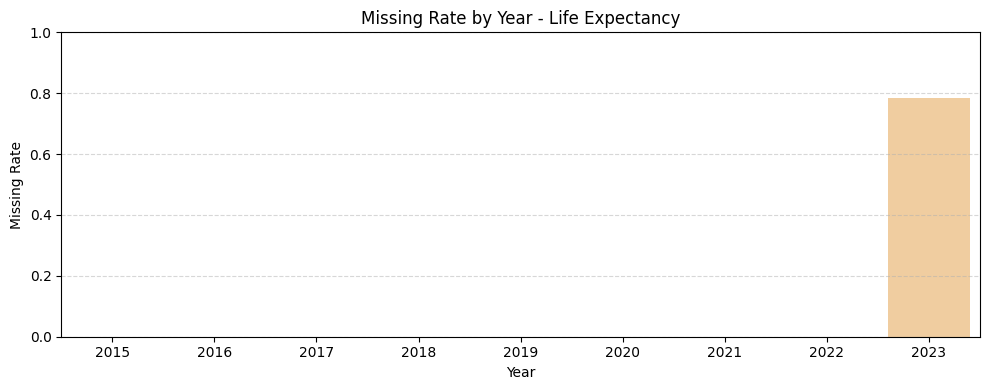

<Figure size 1200x500 with 0 Axes>

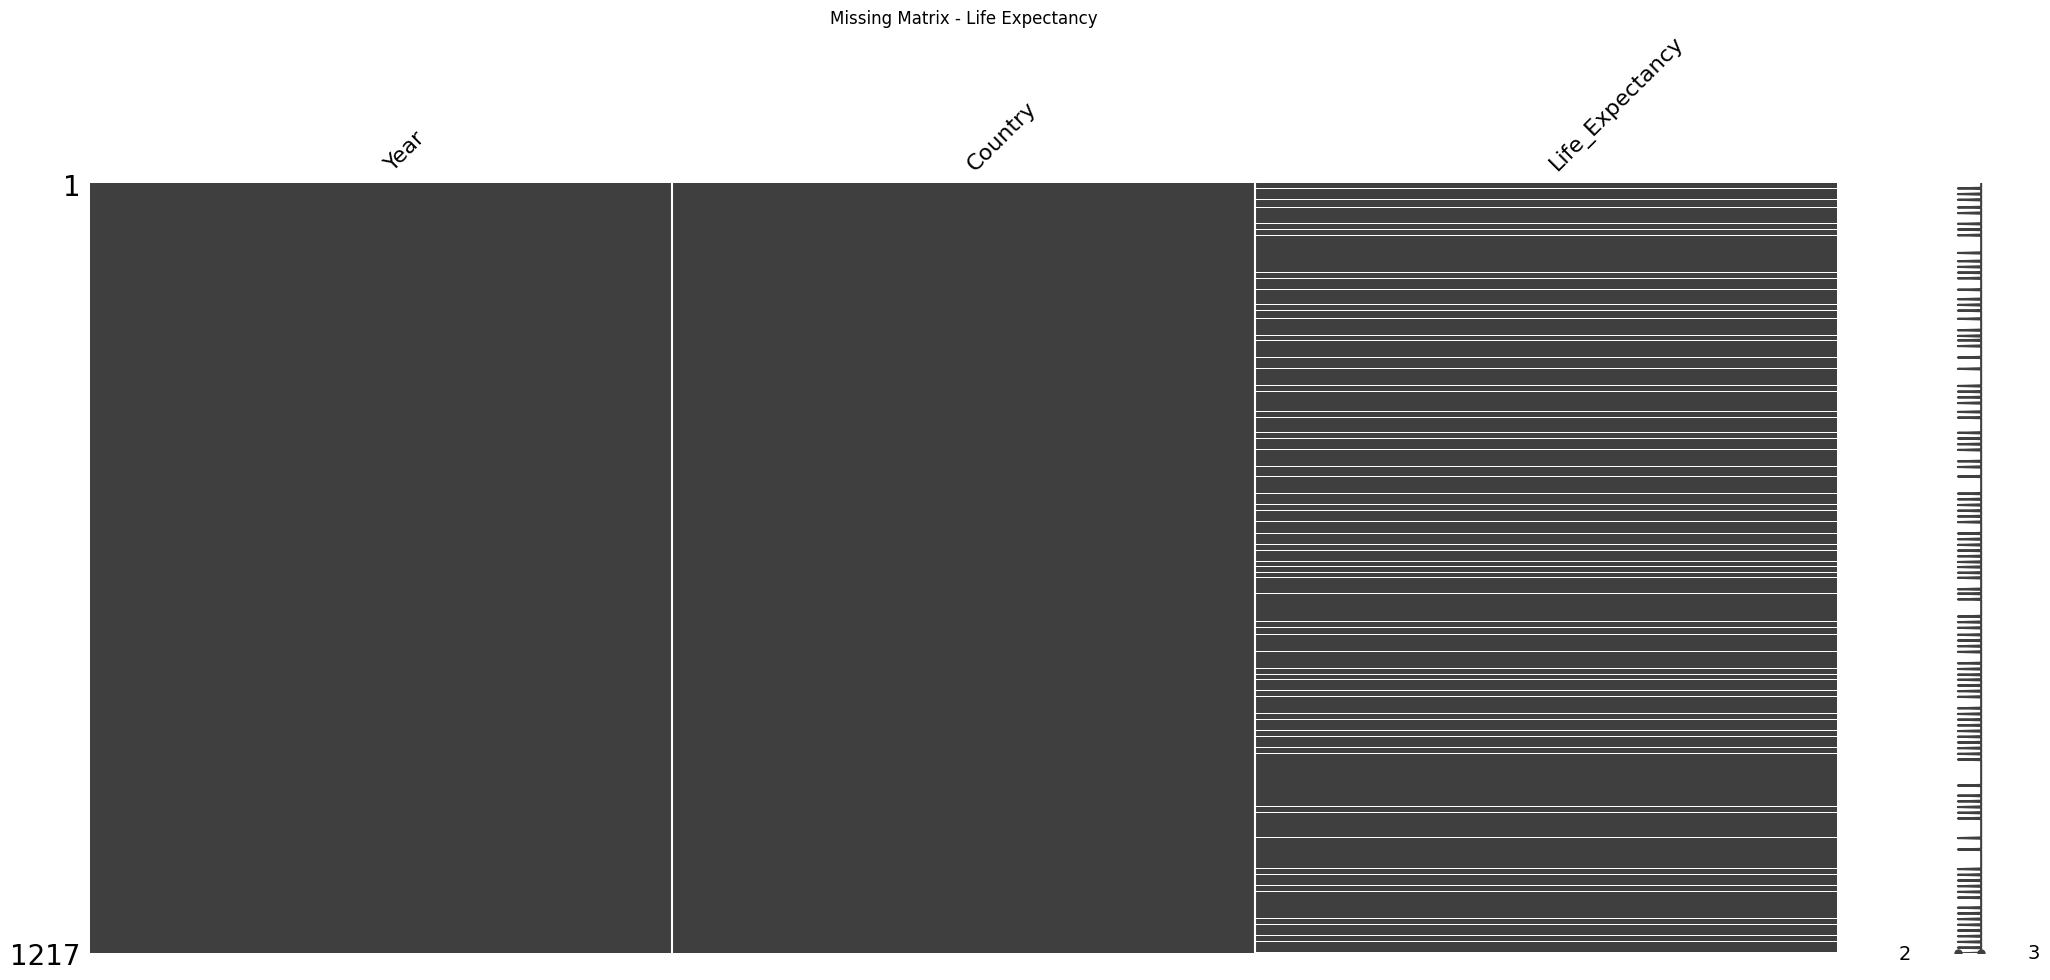



📌 Top 10 countries with the most missing 'Life_Expectancy' entries:
Country
afghanistan        1
montenegro         1
norway             1
north macedonia    1
nigeria            1
niger              1
nicaragua          1
new zealand        1
nepal              1
namibia            1
Name: Year, dtype: int64


In [129]:
import missingno as msno

# Check number and percentage of missing values
missing_summary = merged['Life_Expectancy'].isnull().value_counts()
total_rows = len(merged)
missing_percent = merged['Life_Expectancy'].isnull().mean() * 100

print(f"🔍 Number of missing values in 'Life_Expectancy': {missing_summary.get(True, 0)}")
print(f"📉 Missing rate: {missing_percent:.2f}%")

# Visualise missing rate by year
missing_by_year = (
    merged.groupby('Year')['Life_Expectancy']
    .apply(lambda x: x.isnull().mean())
    .reset_index(name='Missing_Rate')
)

plt.figure(figsize=(10, 4))
sns.barplot(data=missing_by_year, x='Year', y='Missing_Rate', palette='magma')
plt.title("Missing Rate by Year - Life Expectancy")
plt.ylabel("Missing Rate")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Visualise missing pattern matrix
plt.figure(figsize=(12, 5))
msno.matrix(merged[['Year', 'Country', 'Life_Expectancy']])
plt.title("Missing Matrix - Life Expectancy")
plt.show()

# Top 10 countries with most missing values
missing_by_country = (
    merged[merged['Life_Expectancy'].isnull()]
    .groupby('Country')['Year']
    .count()
    .sort_values(ascending=False)
    .head(10)
)

print("\n\n📌 Top 10 countries with the most missing 'Life_Expectancy' entries:")
print(missing_by_country)

### Hypotheses
- Countries with missing life expectancy data in 2023 have systematically lower happiness scores.
- The missingness of life expectancy is not MCAR (Missing Completely At Random), but may be MAR (Missing At Random).
- Lower life expectancy may correlate with lower governmental transparency or data availability.

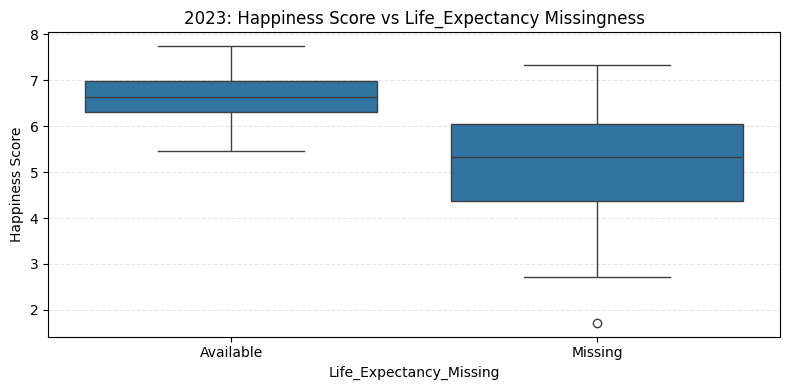



                          count      mean       std    min      25%     50%  \
Life_Expectancy_Missing                                                      
False                     28.0  6.660036  0.555038  5.463  6.30725  6.6435   
True                     102.0  5.241265  1.136334  1.721  4.37325  5.3340   

                             75%    max  
Life_Expectancy_Missing                  
False                    6.98125  7.741  
True                     6.05550  7.341  


In [130]:
# Filter only 2023 data
merged_2023 = merged[merged['Year'] == 2023].copy()

# Create missingness indicator
merged_2023['Life_Expectancy_Missing'] = merged_2023['Life_Expectancy'].isnull()

# Boxplot: Happiness Score by Life_Expectancy availability
plt.figure(figsize=(8, 4))
sns.boxplot(data=merged_2023, x='Life_Expectancy_Missing', y='Happiness Score')
plt.title("2023: Happiness Score vs Life_Expectancy Missingness")
plt.xticks([0, 1], ['Available', 'Missing'])
plt.ylabel("Happiness Score")
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Descriptive statistics
comparison_2023 = merged_2023.groupby('Life_Expectancy_Missing')['Happiness Score'].describe()
print('\n\n',comparison_2023)

### Hypothesis Interpretation and Limitations
- Countries with available 2023 life expectancy data tend to report higher minimum happiness scores and tighter variance, implying they may be technologically advanced or more transparent.
- Although the mean happiness score is clearly lower for countries with missing life expectancy data, the imbalance in group size (103 vs 28) suggests caution in interpreting statistical differences.
- The absence of data in other countries might not directly reflect poor life expectancy, but could stem from limited data infrastructure, delayed reporting cycles, or geopolitical factors.

#### 4.3.1. Creating a missingness indicator column

In [131]:
# Create 2023 missingness flag column
merged['Life_Expectancy_2024_Missing'] = (
    (merged['Year'] == 2023) & merged['Life_Expectancy'].isnull()
)

# Save the updated merged dataset
output_path = "../data/processed/merged_with_2023_flag.csv"
merged.to_csv(output_path, index=False)

### 4.4. Missing value of `Education_Attainment`

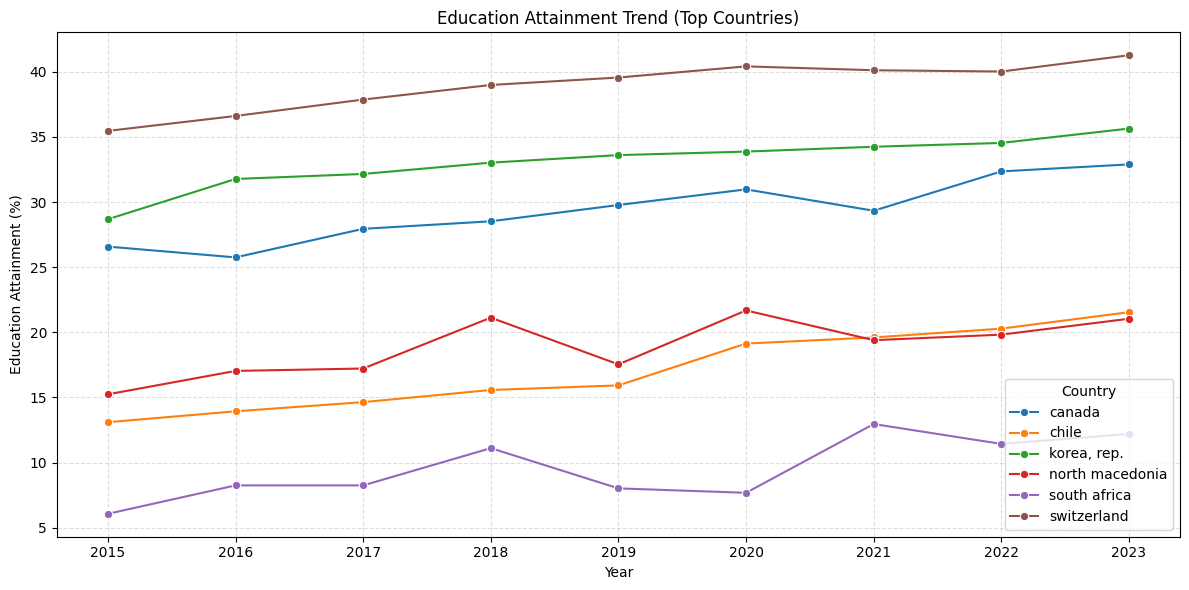

In [132]:
# Top 6 countries with most non-null entries for Education_Attainment
top_countries = (
    merged[~merged['Education_Attainment'].isnull()]
    .groupby('Country')['Education_Attainment']
    .count()
    .sort_values(ascending=False)
    .head(6)
    .index
)

# Filter for plotting
subset = merged[merged['Country'].isin(top_countries)]

# Plot: Lineplot for Education_Attainment by Year and Country
plt.figure(figsize=(12, 6))
sns.lineplot(data=subset, x='Year', y='Education_Attainment', hue='Country', marker='o')
plt.title("Education Attainment Trend (Top Countries)")
plt.ylabel("Education Attainment (%)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

### 4.3 perform time series-based interpolation

🔍 Number of missing values in 'Education_Attainment': 457
📉 Missing rate: 37.55%


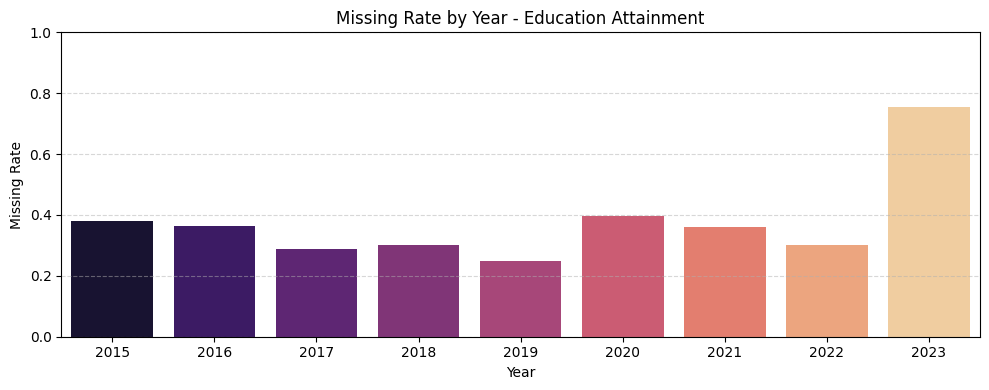

<Figure size 1200x500 with 0 Axes>

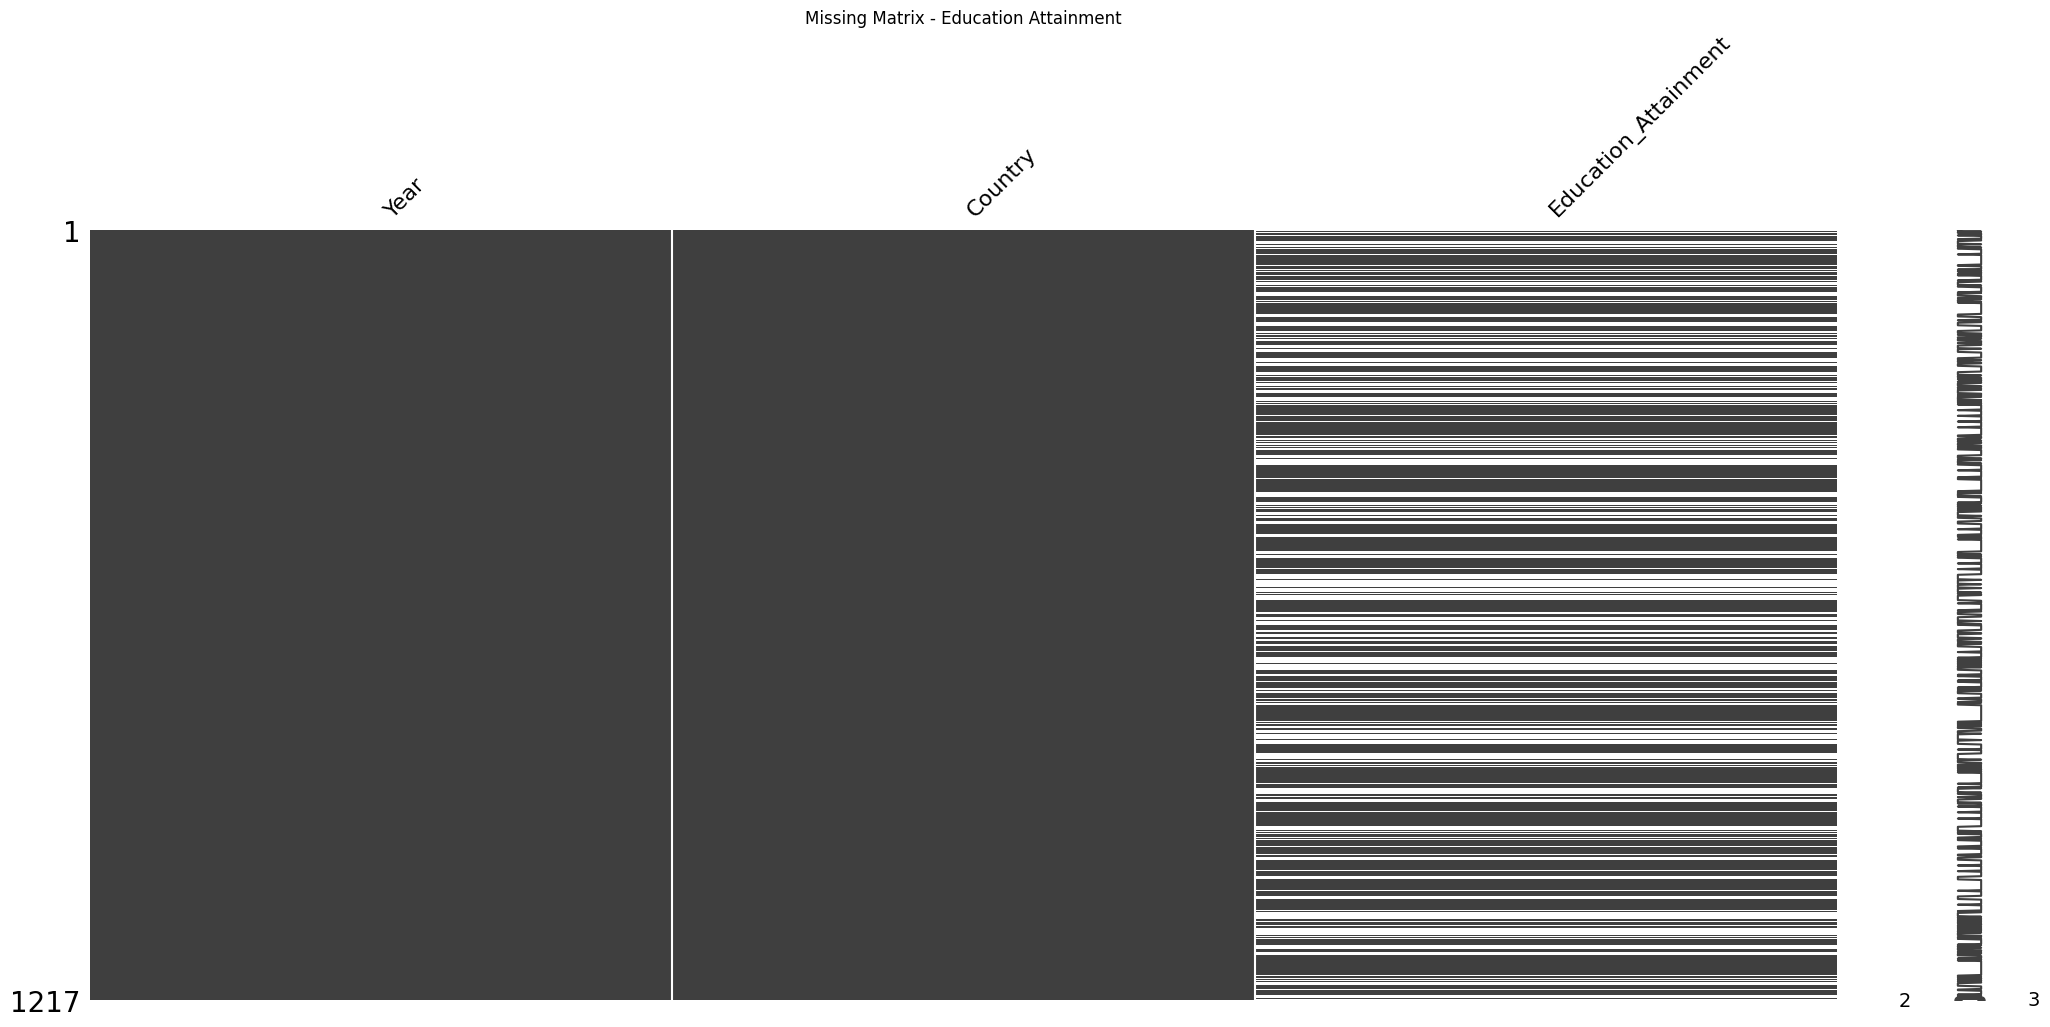



📌 Top 10 countries with the most missing 'Education_Attainment' entries:
Country
russian federation    8
japan                 8
cameroon              8
namibia               8
nepal                 8
nicaragua             8
jordan                8
china                 8
jamaica               8
algeria               8
Name: Year, dtype: int64


In [133]:
import missingno as msno

# Check number and percentage of missing values
missing_summary = merged['Education_Attainment'].isnull().value_counts()
total_rows = len(merged)
missing_percent = merged['Education_Attainment'].isnull().mean() * 100

print(f"🔍 Number of missing values in 'Education_Attainment': {missing_summary.get(True, 0)}")
print(f"📉 Missing rate: {missing_percent:.2f}%")

# Visualise missing rate by year
missing_by_year = (
    merged.groupby('Year')['Education_Attainment']
    .apply(lambda x: x.isnull().mean())
    .reset_index(name='Missing_Rate')
)

plt.figure(figsize=(10, 4))
sns.barplot(data=missing_by_year, x='Year', y='Missing_Rate', palette='magma')
plt.title("Missing Rate by Year - Education Attainment")
plt.ylabel("Missing Rate")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Visualise missing pattern matrix
plt.figure(figsize=(12, 5))
msno.matrix(merged[['Year', 'Country', 'Education_Attainment']])
plt.title("Missing Matrix - Education Attainment")
plt.show()

# Top 10 countries with most missing values
missing_by_country = (
    merged[merged['Education_Attainment'].isnull()]
    .groupby('Country')['Year']
    .count()
    .sort_values(ascending=False)
    .head(10)
)

print("\n\n📌 Top 10 countries with the most missing 'Education_Attainment' entries:")
print(missing_by_country)

In [139]:
# Filter countries where actual data count is zero (i.e. all values missing)
education_fully_missing = merged.groupby('Country')[features_of_missing_values].apply(lambda x: x.isna().all()).reset_index()
education_fully_missing = education_fully_missing[education_fully_missing['Education_Attainment'] == True]

print(f"✅ Countries with all missing education data: {len(education_fully_missing)}")
print(education_fully_missing['Country'].to_markdown(index=False))

✅ Countries with all missing education data: 4
| Country     |
|:------------|
| puerto rico |
| somalia     |
| sudan       |
| suriname    |
